# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
# -- YOUR CODE HERE --
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if 'Positive' in x else 0)

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Сбалансированы ли классы?

In [ ]:
# -- YOUR CODE HERE --
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** классы не сбалансированы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33444 entries, 0 to 33443
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       33444 non-null  int64 
 1   ScreenName     33444 non-null  int64 
 2   Location       26395 non-null  object
 3   TweetAt        33444 non-null  object
 4   OriginalTweet  33444 non-null  object
 5   Sentiment      33444 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.5+ MB


In [ ]:
# -- YOUR CODE HERE --
df.isnull().values.any()
#пропуски в данных есть

True

In [ ]:
df = df.fillna('Unknown')
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1
...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...,1
33440,44950,89902,Unknown,14-04-2020,@MrSilverScott you are definitely my man. I fe...,1
33441,44952,89904,Unknown,14-04-2020,Response to complaint not provided citing COVI...,0
33442,44953,89905,Unknown,14-04-2020,You know itÃÂs getting tough when @KameronWi...,1


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23410 entries, 25621 to 2732
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       23410 non-null  int64 
 1   ScreenName     23410 non-null  int64 
 2   Location       23410 non-null  object
 3   TweetAt        23410 non-null  object
 4   OriginalTweet  23410 non-null  object
 5   Sentiment      23410 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.3+ MB


## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
# для удобства реализуем функцию, которая пройдется по всем текстам и создаст словарь частоты встречаемости токенов

def count_tokens(train):
    token_counts = {}
    for text in train:
        tokens = text.lower().split()
        for token in tokens:
            if token in token_counts:
                token_counts[token] += 1
            else:
                token_counts[token] = 1
    return token_counts

token_counts = count_tokens(train['OriginalTweet'])
token_counts

{'why': 654,
 'we': 3787,
 'still': 763,
 'want': 487,
 'to': 23373,
 'buy': 748,
 'so': 1837,
 'much': 482,
 'stuff': 106,
 'during': 1908,
 'quarantine': 154,
 'https://t.co/1m881cwfuv': 1,
 '#shopping': 121,
 '#covid_19': 1660,
 '#online': 40,
 'with': 4063,
 'driving': 77,
 'even': 682,
 'more': 2008,
 'usage': 22,
 'a': 11737,
 'strong': 93,
 'strategy': 33,
 'is': 7383,
 'critical': 156,
 'now': 1349,
 'then': 435,
 'ever': 179,
 'luckily': 8,
 'and': 14684,
 'april': 163,
 '16': 36,
 'webinar': 65,
 'will': 2726,
 'dive': 10,
 'into': 666,
 'growing': 84,
 'app': 52,
 'awareness': 32,
 'targeting': 9,
 'high': 408,
 'lifetime': 4,
 'value': 79,
 'users': 19,
 '@canon_india': 16,
 'i': 5340,
 'am': 424,
 'very': 418,
 'happy..': 1,
 'great': 409,
 'job': 242,
 'by': 2236,
 '#canonforcommunity': 5,
 'https://t.co/z0intks34x': 1,
 'the': 26815,
 'u.s': 8,
 'national': 123,
 'debt': 68,
 'likely': 170,
 'exceed': 14,
 '$30': 7,
 'trillion': 21,
 'after': 886,
 'unprecedented': 89,
 

Какой размер словаря получился?

In [ ]:
len(token_counts)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [ ]:
# -- YOUR CODE HERE --
sorted(token_counts.items(), key=lambda item: item[1], reverse=True)[:10]

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** Как мы видим, самыми популярными токенам в массе своей являются артикли, предлоги и главгол to be, из общей картины выбивается лишь хэштэг coronavirus, но это объясняется тематикой твитов. Таким образом, самыми популярными токенами являются стоп-слова

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

token_counts
stop_words = set(stopwords.words('english'))
for word in list(token_counts.keys()):
    if word in stop_words:
        del token_counts[word]

sorted(token_counts.items(), key=lambda item: item[1], reverse=True)[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:**  теперь токены стали более информативными и большинство связаны с тематикой ковида

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
sorted(token_counts.items(), key=lambda item: item[1], reverse=False)[:20]

[('https://t.co/1m881cwfuv', 1),
 ('happy..', 1),
 ('https://t.co/z0intks34x', 1),
 ('mnuchinã\x82â\x92s', 1),
 ('brink.', 1),
 ('https://t.co/jmobv8z0u0', 1),
 ("university's", 1),
 ('teaching.)', 1),
 ('@catholicpres', 1),
 ('@catholicuniv', 1),
 ('https://t.co/evqby035wf', 1),
 ('https://t.co/riqrhxxeim', 1),
 ('@@ballardspahrll', 1),
 ('#aca', 1),
 ('easier...take', 1),
 ('ã\x82â\x93necessaryã\x82â\x94', 1),
 ('https://t.co/0fmsmlgepm', 1),
 ('husted:', 1),
 ('irishman', 1),
 ('#happystpatricksday!', 1)]

**Ответ:** данные токены являются либо ссылками, либо чьими-то никами, судя по всему, либо крайне непопулярными речевыми оборотами, глобально, я думаю, с подобными «выбросами» работать нужно, но то, что вывел код в нашем случае, особо не важно для каких-либо выводов о тональности твита



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

token_counts_tt = {}
for text in train['OriginalTweet']:
  tokens = tokenizer.tokenize(text)
  for token in tokens:
    if token in token_counts_tt:
      token_counts_tt[token] += 1
    else:
      token_counts_tt[token] = 1

sorted(token_counts_tt.items(), key=lambda item: item[1], reverse=True)[:10]

[('the', 24337),
 ('.', 24118),
 ('to', 22933),
 (',', 17571),
 ('and', 14354),
 ('of', 12904),
 ('a', 11045),
 ('in', 10573),
 ('?', 9524),
 ('for', 8228)]

**Ответ:** отличается тем, что теперь среди самых популярных токенов не только артикли и предлоги, но и знаки препинания

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
from string import punctuation

noise = stopwords.words('english') + list(punctuation)
for word in list(token_counts_tt.keys()):
    if word in noise:
        del token_counts_tt[word]

sorted(token_counts_tt.items(), key=lambda item: item[1], reverse=True)[:10]

[('Â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('#coronavirus', 7143),
 ('I', 5235),
 ('\x92', 4372),
 ('prices', 4281),
 ('COVID', 4218),
 ('food', 3795),
 ('store', 3691)]

**Ответ:** # начинает появляться, но все еще есть странные символы, вероятно, куски кодировки

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
for word in list(token_counts_tt.keys()):
    if len(word) == 1 and ord(word) >= 128:
        del token_counts_tt[word]

print('топ-10 популярных', '\n', sorted(token_counts_tt.items(), key=lambda item: item[1], reverse=True)[:10])
print('топ-20 непопулярных', '\n', sorted(token_counts_tt.items(), key=lambda item: item[1], reverse=False)[:20])

топ-10 популярных 
 [('19', 7167), ('#coronavirus', 7143), ('I', 5235), ('prices', 4281), ('COVID', 4218), ('food', 3795), ('store', 3691), ('supermarket', 3373), ('grocery', 3083), ('people', 3047)]
топ-20 непопулярных 
 [('https://t.co/1m881CwFUv', 1), ('https://t.co/Z0intkS34x', 1), ('MnuchinÃ', 1), ('https://t.co/JmoBv8z0U0', 1), ("University's", 1), ('@CatholicPres', 1), ('@CatholicUniv', 1), ('https://t.co/EvQby035wF', 1), ('https://t.co/rIQrhxxeIM', 1), ('@BallardSpahrLL', 1), ('#training', 1), ('#aca', 1), ('https://t.co/0FmSmlGePM', 1), ('Irishman', 1), ('#HappyStPatricksDay', 1), ('Guiness', 1), ('https://t.co/18V0PYHwb7', 1), ('https://t.co/LS0g86i8PU', 1), ('https://t.co/oFVkejfF23', 1), ('https://t.co/Xoodgd2uLx', 1)]


**Ответ:**  полученные топы мало различаются между собой, разве что количественно, а качественно они очен схожи

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
hashtags_token_counts_tt = token_counts_tt
for word in list(hashtags_token_counts_tt.keys()):
  if '#' not in word:
    del hashtags_token_counts_tt[word]


sorted(hashtags_token_counts_tt.items(), key=lambda item: item[1], reverse=True)[:10]

[('#coronavirus', 7143),
 ('#COVID19', 1844),
 ('#Covid_19', 1463),
 ('#Coronavirus', 1281),
 ('#COVID2019', 927),
 ('#toiletpaper', 657),
 ('#covid19', 568),
 ('#COVID', 542),
 ('#CoronaCrisis', 426),
 ('#CoronaVirus', 351)]

**Ответ:**  все хештеги так или иначе связаны с коронавирусом

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
links_token_counts_tt = token_counts_tt

for word in list(links_token_counts_tt.keys()):
  if 'https://t.co' not in word:
    del links_token_counts_tt[word]


sorted(links_token_counts_tt.items(), key=lambda item: item[1], reverse=True)[:10]

[('https://t.co/oXA7SWtoNd', 5),
 ('https://t.co/gP3EusapL8', 4),
 ('https://t.co/DefTruI1PfÃ\x82Â', 3),
 ('https://t.co/WrLHYzIzAA', 3),
 ('https://t.co/kuwIpF1KQW', 3),
 ('https://t.co/zjNRx6dKKN', 3),
 ('https://t.co/3GBBDpdjat', 3),
 ('https://t.co/e2ZNXajPre', 3),
 ('https://t.co/CATKegAyOY', 3),
 ('https://t.co/G63RP042HO', 3)]

**Ответ:** информация о ссылке на конкретную страницу полезна не будет, так как ее очень мало (в сравнении с теми же хештегами)

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):

  text = text.lower()
  tokenizer = TweetTokenizer()
  tokens = tokenizer.tokenize(text)
  noise = set(stopwords.words('english') + list(punctuation))
  correct_tokens = []
  for token in tokens:
    if (token not in noise) and (len(token) != 1 or ord(token) < 128) and (not token.startswith('https://t.co')):
        correct_tokens.append(token)

  return correct_tokens

In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer = custom_tokenizer)
cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** данный словарь сильно меньше изначального словаря из задания 2


Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
vectorized_text = cv.transform([train.iloc[ind]['OriginalTweet']])
vectorized_text_array = vectorized_text.toarray()

#определим индексы максимальной и минимальной компоненты без учета нулей
max_index = np.argmax(vectorized_text_array)
min_index = np.argmin(vectorized_text_array[vectorized_text_array.nonzero()])

#получаем список всех токенов
tokens = cv.get_feature_names_out()

#находим соответствующие токены по найденным индексам
most_important_token = tokens[max_index]
least_important_token = tokens[min_index]

print("Most important token:", most_important_token)
print("Least important token:", least_important_token)

Most important token: #coronavirusoutbreak
Least important token: ###covid-19


**Ответ:** непонятно, откуда взялся ###covid-19, ведь его вовсе нет в тексте твита, а самым важным определился хештег про распространение коронавируса, что мне кажется не вполне хорошим, ведь многие твиты могут быть с таким хештегом по тематике пандемии, что не добавляет этому токену важности

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer = custom_tokenizer)
tfidf_vec.fit_transform(train['OriginalTweet'])

vectorized_text_tfidf = tfidf_vec.transform([train.iloc[ind]['OriginalTweet']])
vectorized_text_tfidf_array = vectorized_text_tfidf.toarray()

#определим индексы максимальной и минимальной компоненты без учета нулей
max_index_tfidf = np.argmax(vectorized_text_tfidf_array)
min_index_tfidf = np.argmin(vectorized_text_tfidf_array[vectorized_text_tfidf_array.nonzero()])

#получаем список всех токенов
tokens_tfidf = tfidf_vec.get_feature_names_out()

#находим соответствующие токены по найденным индексам
most_important_token_tfidf = tokens_tfidf[max_index_tfidf]
least_important_token_tfidf = tokens_tfidf[min_index_tfidf]

print("Most important token Tfidf:", most_important_token_tfidf)
print("Least important token Tfidf:", least_important_token_tfidf)

Most important token Tfidf: brainless
Least important token Tfidf: #01


**Ответ:** самый важный токен, на мой взгляд, определился хорошо, слово brainless подчеркивает сильно негативный тон текста и, судя по всему, не сильно распространено в остальных текстах корпуса. Самый неважный токен не особо информативен

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
df_positive = train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]
df_positive

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
3281,7772,52724,"Nairobi, Kenya",18-03-2020,Crisp clean fresh air perfect ambience Covid 1...,1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [ ]:
df_positive['OriginalTweet'].iloc[1]

'Let s just take a minute to say THANK YOU also to the amazing postal workers So many real people behind a click of online shopping and getting cards delivered Thank   you   19'

In [ ]:
vectorized_text_tfidf = tfidf_vec.transform([df_positive['OriginalTweet'].iloc[1]])
vectorized_text_tfidf_array = vectorized_text_tfidf.toarray()

#определим индексы максимальной и минимальной компоненты без учета нулей
max_index_tfidf = vectorized_text_tfidf.argmax()
min_index_tfidf = np.argmin(vectorized_text_tfidf[vectorized_text_tfidf.nonzero()])

#получаем список всех токенов
tokens_tfidf = tfidf_vec.get_feature_names_out()

#находим соответствующие токены по найденным индексам
most_important_token_tfidf = tokens_tfidf[max_index_tfidf]
least_important_token_tfidf = tokens_tfidf[min_index_tfidf]

print("Most important token Tfidf:", most_important_token_tfidf)

Most important token Tfidf: thank


**Ответ:**  на данном тексте хорошо сработало, выделилось слово «поблагодарить», что подчеркивает положительный тон твита

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:
#выделяем целевую переменную, делим на трейн и тест
X_train = train['OriginalTweet']
X_test = test['OriginalTweet']
y_train = train['Sentiment']
y_test = test['Sentiment']

X_train_cv = cv.fit_transform(X_train) # обучили CountVectorizer
X_train_tfidf = tfidf_vec.fit_transform(X_train) # обучили Tfidf
X_test_cv = cv.transform(X_test)
X_test_tfidf = tfidf_vec.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg_cv = LogisticRegression(max_iter=1000)
log_reg_cv.fit(X_train_cv, y_train)

log_reg_tfidf = LogisticRegression(max_iter=1000)
log_reg_tfidf.fit(X_train_tfidf, y_train)

print('Accuracy on train (CV)', accuracy_score(y_train, log_reg_cv.predict(X_train_cv)))
print('Accuracy on test (CV)', accuracy_score(y_test, log_reg_cv.predict(X_test_cv)))
print('Accuracy on train (Tfidf)', accuracy_score(y_train, log_reg_tfidf.predict(X_train_tfidf)))
print('Accuracy on test (Tfidf)', accuracy_score(y_test, log_reg_tfidf.predict(X_test_tfidf)))

Accuracy on train (CV) 0.9844510892780863
Accuracy on test (CV) 0.8672513454255532
Accuracy on train (Tfidf) 0.9254592054677488
Accuracy on test (Tfidf) 0.8533984452860275


**Ответ:**  у CV доля верных ответов выше как на обучающих, так и на тестовых данных, однако разница относительно не очень большая (во всех случаях accuracy высокий), что позволяет нам сделать препдоложение о ее корректной работе (переобучения нет)

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [ ]:
from nltk.stem.snowball import SnowballStemmer
def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer('english')
  text = text.lower()
  tokenizer = TweetTokenizer()
  tokens = tokenizer.tokenize(text)
  noise = set(stopwords.words('english') + list(punctuation))
  correct_tokens_stem = []
  for token in tokens:
    if (token not in noise) and (len(token) != 1 or ord(token) < 128) and (not token.startswith('https://t.co')):
        stemmed_token = stemmer.stem(token)
        correct_tokens_stem.append(stemmed_token)
  return correct_tokens_stem

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [70]:
cv = CountVectorizer(tokenizer = custom_stem_tokenizer)
tfidf_vec = TfidfVectorizer(tokenizer = custom_stem_tokenizer)
cv.fit_transform(train['OriginalTweet'])
tfidf_vec.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

36652


**Ответ** размер словаря стал меньше

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [71]:

X_train_cv = cv.fit_transform(X_train) # обучили CountVectorizer
X_train_tfidf = tfidf_vec.fit_transform(X_train) # обучили Tfidf
X_test_cv = cv.transform(X_test)
X_test_tfidf = tfidf_vec.transform(X_test)

log_reg_cv = LogisticRegression(max_iter=1000)
log_reg_cv.fit(X_train_cv, y_train)

log_reg_tfidf = LogisticRegression(max_iter=1000)
log_reg_tfidf.fit(X_train_tfidf, y_train)

print('Accuracy on train (CV)', accuracy_score(y_train, log_reg_cv.predict(X_train_cv)))
print('Accuracy on test (CV)', accuracy_score(y_test, log_reg_cv.predict(X_test_cv)))
print('Accuracy on train (Tfidf)', accuracy_score(y_train, log_reg_tfidf.predict(X_train_tfidf)))
print('Accuracy on test (Tfidf)', accuracy_score(y_test, log_reg_tfidf.predict(X_test_tfidf)))

Accuracy on train (CV) 0.9718923536950022
Accuracy on test (CV) 0.8672513454255532
Accuracy on train (Tfidf) 0.9158906450234943
Accuracy on test (Tfidf) 0.8560892963922663


**Ответ:** accuracy на обучающих выборках стал ниже. На тестовой выборке при использовании tfidf accuracy стал на ~0.3 выше, а при использовании CV не изменился. Так что можно сделать предположение, что при использовании tfidf стемминг позволяет достичь большей доли верных ответов




## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=0.3
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


**Ответ:** значение 0.3 говорит нам о том, что с данным ограничением мы оставляем только токены встречаются в 30 процентах текстов корпуса и меньше, а следовательно, являются относительно часто встречающимися, поэтому при таком не высоком показателе max_df размер словаря несильно меняется. В целом, делаем вывод о том, что самая большая частота встречаемости токенов в текстах корпуса является равным примерно 0.3

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.00045
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3700


**Ответ:** можно сделать предположение о том, что твиты между собой очень похожи (большинство токенов встречается очень часто), раз для того, чтобы настолько сократить изначальный словарь надо поставить настолько маленькое значение минимальной частоты встречаемости

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

bow_train = cv_df.transform(X_train)
bow_test = cv_df.transform(X_test)

scaler = MaxAbsScaler()

X_train_transformed = scaler.fit_transform(bow_train)
X_test_transformed = scaler.transform(bow_test)

log_reg_cv = LogisticRegression(max_iter=1000)
log_reg_cv.fit(X_train_transformed, y_train)

print('Accuracy on train (CV with stem) size 3700:', accuracy_score(y_train, log_reg_cv.predict(X_train_transformed)))
print('Accuracy on test (CV with stem) size 3700:', accuracy_score(y_test, log_reg_cv.predict(X_test_transformed)))


Accuracy on train (CV with stem) size 3700: 0.9176420333190944
Accuracy on test (CV with stem) size 3700: 0.8611720151484951


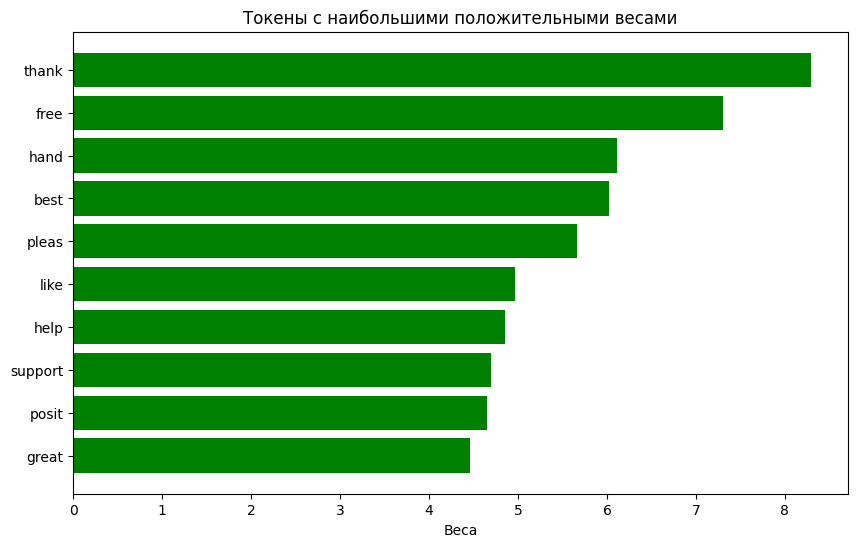

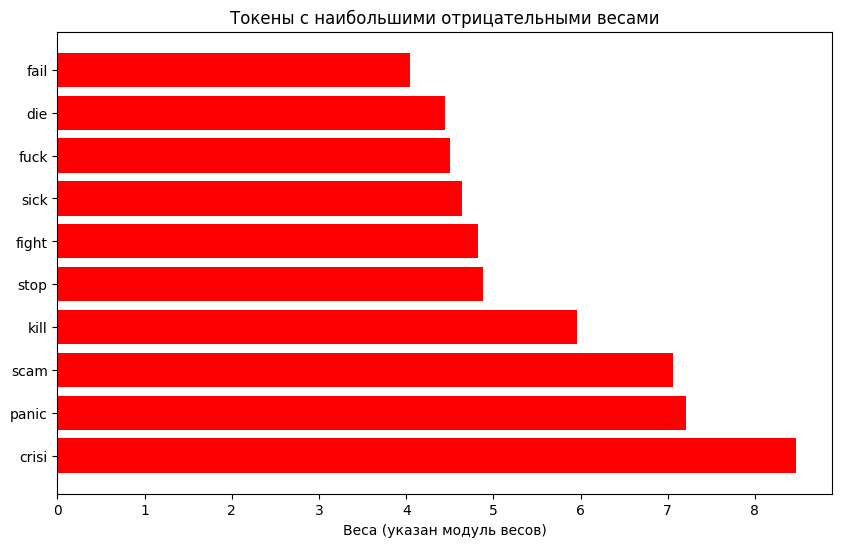

In [ ]:
import matplotlib.pyplot as plt

#получаем веса
coefficients = log_reg_cv.coef_[0]

#получаем индексы токенов с наибольшими и наименьшими весами
positive_indices = np.argsort(coefficients)[-10:]
negative_indices = np.argsort(coefficients)[:10]

#получаем список всех токенов
tokens_for_plot = cv_df.get_feature_names_out()

#получаем списки весов позитивных токенов
positive_tokens = [tokens_for_plot[idx] for idx in positive_indices]
positive_weights = [coefficients[idx] for idx in positive_indices]

#получаем списки весов негативных токенов
negative_tokens = [tokens_for_plot[idx] for idx in negative_indices]
negative_weights = [np.abs(coefficients[idx]) for idx in negative_indices]

#barplot для токенов с наибольшими положительными весами
plt.figure(figsize=(10, 6))
plt.barh(positive_tokens, positive_weights, color='green')
plt.xlabel('Веса')
plt.title('Токены с наибольшими положительными весами')
plt.show()

#barplot для токенов с наибольшими отрицательными весами
plt.figure(figsize=(10, 6))
plt.barh(negative_tokens, negative_weights, color='red')
plt.xlabel('Веса (указан модуль весов)')
plt.title('Токены с наибольшими отрицательными весами')
plt.show()

**Ответ:** каждый токен является ярко выраженным и отсылает к тону сообщения

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
train['UserName'].value_counts() #все значения уникальны, аналогичная ситуация с ScreenName —> признаки неинформативны

UserName
35178    1
35598    1
26660    1
9581     1
8447     1
        ..
20801    1
30276    1
20045    1
32319    1
7104     1
Name: count, Length: 23410, dtype: int64

In [ ]:
train['ScreenName'].value_counts()

ScreenName
80130    1
80550    1
71612    1
54533    1
53399    1
        ..
65753    1
75228    1
64997    1
77271    1
52056    1
Name: count, Length: 23410, dtype: int64

**Ответ:** признаки неинформативны

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
train['TweetAt'].value_counts()

TweetAt
2020-03-20    1996
2020-03-19    1844
2020-03-25    1742
2020-03-18    1619
2020-03-21    1531
2020-03-22    1225
2020-03-23    1174
2020-03-17    1103
2020-08-04    1044
2020-07-04    1010
2020-06-04     956
2020-09-04     847
2020-03-24     843
2020-04-13     802
2020-03-26     713
2020-05-04     614
2020-10-04     545
2020-02-04     537
2020-11-04     528
2020-12-04     446
2020-03-04     446
2020-04-04     438
2020-03-16     402
2020-01-04     347
2020-03-31     188
2020-03-27     179
2020-04-14     159
2020-03-29      69
2020-03-30      47
2020-03-28      16
Name: count, dtype: int64

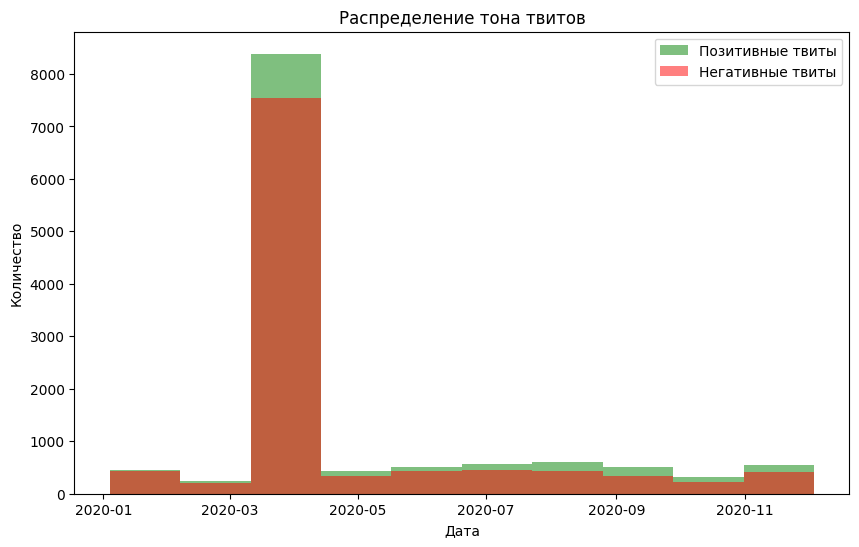

In [ ]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='mixed')

positive_tweets = train[train['Sentiment'] == 1]
negative_tweets = train[train['Sentiment'] == 0]

plt.figure(figsize=(10, 6))
plt.hist(positive_tweets['TweetAt'], color='green', alpha=0.5, label='Позитивные твиты')
plt.hist(negative_tweets['TweetAt'], color='red', alpha=0.5, label='Негативные твиты')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.title('Распределение тона твитов')
plt.legend()
plt.show()

**Ответ:** данные по датам неинформативны для нашей классификации текстов



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
# -- YOUR CODE HERE --
train['Location'].nunique()
#7949 уникальных значений

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [ ]:
train[train['Location'] != 'Unknown']['Location'].value_counts().head(10)

Location
London             301
United States      295
London, England    274
New York, NY       223
Washington, DC     222
United Kingdom     204
Los Angeles, CA    154
India              153
UK                 133
Australia          118
Name: count, dtype: int64

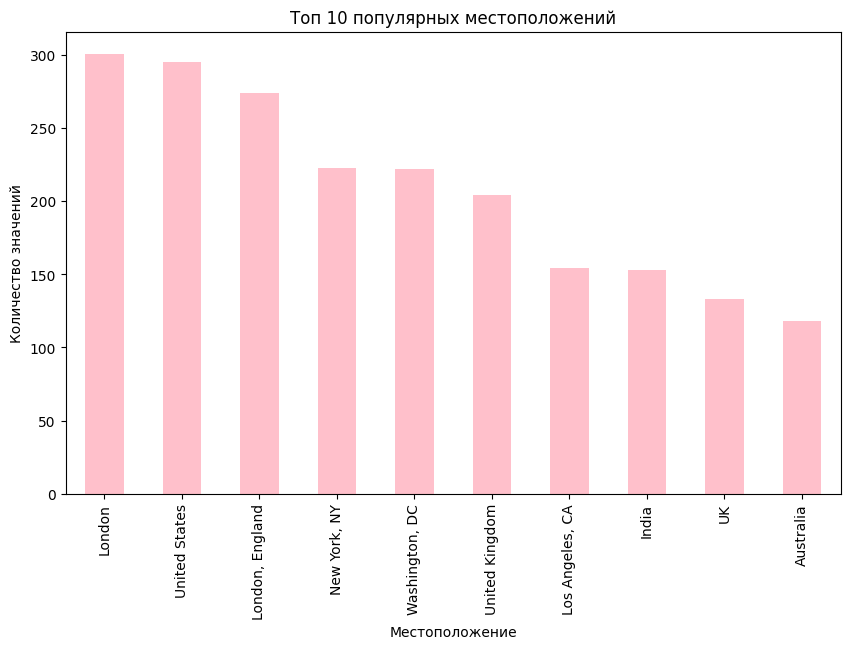

In [ ]:
plt.figure(figsize=(10, 6))
train[train['Location'] != 'Unknown']['Location'].value_counts().head(10).plot(kind='bar', color='pink')
plt.title('Топ 10 популярных местоположений')
plt.xlabel('Местоположение')
plt.ylabel('Количество значений')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
# -- YOUR CODE HERE --
train['WiderLocation'] = train['Location'].apply(lambda x: x if len(x.split(',')) == 1 else x.split(',')[1])
train['WiderLocation'].nunique()
# 5209 уникальных значений

5209

In [ ]:
train[train['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts().head(10)

WiderLocation
 England         838
 USA             776
 CA              599
 NY              378
 India           375
London           302
United States    295
 TX              262
 DC              229
 Ontario         228
Name: count, dtype: int64

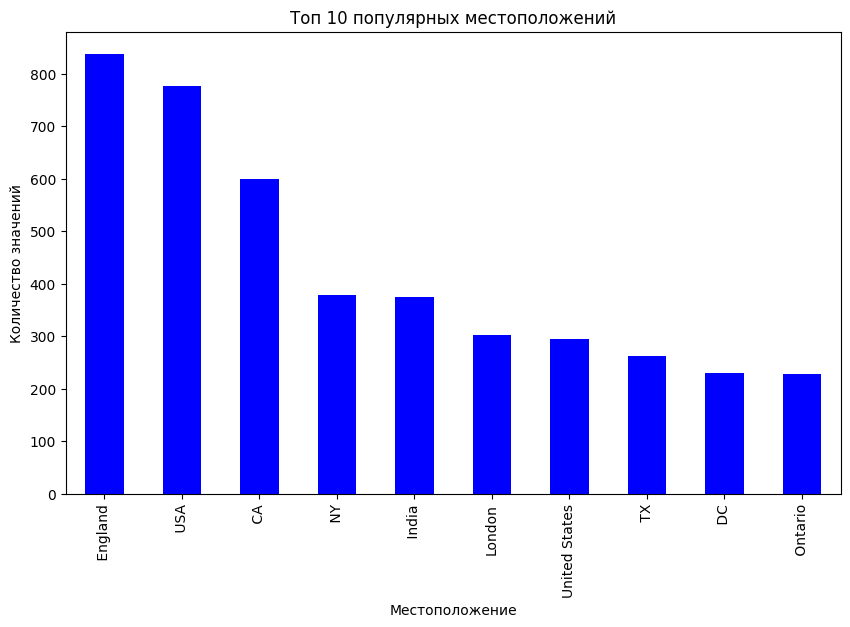

In [ ]:
plt.figure(figsize=(10, 6))
train[train['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts().head(10).plot(kind='bar', color='blue')
plt.title('Топ 10 популярных местоположений')
plt.xlabel('Местоположение')
plt.ylabel('Количество значений')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [67]:
from sklearn.preprocessing import OneHotEncoder

#список местоположение, встречающихся в датасете больше 1 раза
locations_mto = train['WiderLocation'].value_counts()[train['WiderLocation'].value_counts() > 1].index

encoded_locations_train = train['WiderLocation'].apply(lambda x: x if x in locations_mto else 'Other').values.reshape(-1, 1)

encoder = OneHotEncoder(drop='first', dtype='int')
encoded_locations_train = encoder.fit_transform(encoded_locations_train).toarray()

encoded_feature_names = encoder.get_feature_names_out(['WiderLocation'])

#датафрейм с закодированными признаками
encoded_locations_train = pd.DataFrame(encoded_locations_train, columns=encoded_feature_names)

encoded_locations_train = encoded_locations_train.drop(columns='WiderLocation_Other')

encoded_locations_train #1163 значения

,WiderLocation_,WiderLocation_ MN,WiderLocation_ 15401,WiderLocation_ ? ??? ?t ?? l???? ?t ??,WiderLocation_ ??,WiderLocation_ ?? ??????,WiderLocation_ ????,WiderLocation_ ?????,WiderLocation_ ????? ????,WiderLocation_ ??????,...,WiderLocation_she/her,WiderLocation_sheffield,WiderLocation_somewhere,WiderLocation_texas,WiderLocation_uk,WiderLocation_up,WiderLocation_usa,WiderLocation_worldwide,WiderLocation_||somali|kenyan??,WiderLocation_ÃÂ¯\_(?)_/ÃÂ¯
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#тоже самое для тестовой выборки
test['WiderLocation'] = test['Location'].apply(lambda x: x if len(x.split(',')) == 1 else x.split(',')[1])

encoded_locations_test = test['WiderLocation'].apply(lambda x: x if x in locations_mto else 'Other').values.reshape(-1, 1)

encoded_locations_test = encoder.transform(encoded_locations_test).toarray()

encoded_locations_test = pd.DataFrame(encoded_locations_test, columns=encoded_feature_names) #категории взяли из ячейки с трейном, вместо параметра categories в энкодере передали их в датфрейм в качестве колонок

encoded_locations_test = encoded_locations_test.drop(columns='WiderLocation_Other')

encoded_locations_test #1163 значения

,WiderLocation_,WiderLocation_ MN,WiderLocation_ 15401,WiderLocation_ ? ??? ?t ?? l???? ?t ??,WiderLocation_ ??,WiderLocation_ ?? ??????,WiderLocation_ ????,WiderLocation_ ?????,WiderLocation_ ????? ????,WiderLocation_ ??????,...,WiderLocation_she/her,WiderLocation_sheffield,WiderLocation_somewhere,WiderLocation_texas,WiderLocation_uk,WiderLocation_up,WiderLocation_usa,WiderLocation_worldwide,WiderLocation_||somali|kenyan??,WiderLocation_ÃÂ¯\_(?)_/ÃÂ¯
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
#объединим матрицы скалированных текстовых данных и матрицы с новыми признаками
new_matrix_train = np.hstack((X_train_transformed.toarray(), encoded_locations_train.values))
new_matrix_train.shape

(23410, 4863)

In [ ]:
new_matrix_test = np.hstack((X_test_transformed.toarray(), encoded_locations_test.values))
new_matrix_test.shape

(10034, 4863)

In [ ]:
log_reg_cv = LogisticRegression(max_iter=1000)
log_reg_cv.fit(new_matrix_train, y_train)

print('Accuracy on train (CV with stem) size 3700 with ohe location:', accuracy_score(y_train, log_reg_cv.predict(new_matrix_train)))
print('Accuracy on test (CV with stem) size 3700 with ohe location:', accuracy_score(y_test, log_reg_cv.predict(new_matrix_test)))

Accuracy on train (CV with stem) size 3700 with ohe location: 0.9234515164459632
Accuracy on test (CV with stem) size 3700 with ohe location: 0.8577835359776759


**Ответ:** полезным признак не оказался, чуть повысил accuracy на трейне и понизил на тесте

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --